In [2]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"
if not os.path.exists(pdf_path):
  print("File does't exiest, downloading")
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
  filename = pdf_path
  response = requests.get(url)

  if response.status_code == 200:
    with open(filename,"wb") as file:
      file.write(response.content)
    print(f"the file has been downloaded and saved as {filename}")
  else:
    print(f"Failed to download the file.status code: {response.status_code}")

else:
    print(f"File{pdf_path} exists.")

File does't exiest, downloading
the file has been downloaded and saved as human-nutrition-text.pdf


In [3]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
  cleaned_text = text.replace("\n"," ").strip()
  return cleaned_text

def open_and_reaad_pdf(pdf_path: str) ->list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []
  for page_number,page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text)
    pages_and_texts.append({"page_number":page_number - 41,
                            "page_char_count":len(text),
                            "page_word_count":len(text.split(" ")),
                            "page_sentence_count_raw":len(text.split(". ")),
                            "page_token_count":len(text)/4,
                            "text":text})
  return pages_and_texts

pages_and_texts=open_and_reaad_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [4]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [5]:
df.describe().round(3)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.000,1208.000,1208.000,1208.000,1208.000
mean,562.500,1148.004,199.499,10.520,287.001
std,348.864,560.382,95.831,6.548,140.096
min,-41.000,0.000,1.000,1.000,0.000
25%,260.750,762.000,134.000,5.000,190.500
50%,562.500,1231.500,216.000,10.000,307.875
75%,864.250,1603.500,272.000,15.000,400.875
max,1166.000,2308.000,430.000,39.000,577.000


In [6]:
from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [7]:
from os.path import split
num_sentence_chunk_size = 10

def split_list(input_list: list,slice_size: int) -> list[list[str]]:
  return [input_list[i:i+slice_size] for i in range(0, len(input_list),slice_size)]

for item in tqdm(pages_and_texts):
  item["sentence_chunk"] = split_list(input_list=item["sentences"],slice_size=num_sentence_chunk_size)
  item["num_chunks"] = len(item["sentence_chunk"])


  0%|          | 0/1208 [00:00<?, ?it/s]

In [8]:
import random
random.sample(pages_and_texts,k=1)

[{'page_number': 286,
  'page_char_count': 1266,
  'page_word_count': 252,
  'page_sentence_count_raw': 10,
  'page_token_count': 316.5,
  'text': 'HFCS  • high  fructose  corn syrup  Dry  form: 4  kcal/g;  Liquid  form: 3  kcal/g  Corn is milled to  produce corn  starch, then the  cornstarch is  further processed  to yield corn syrup.  Controversial  because it is found  ubiquitously in  processed food  products, which  could lead to  overconsumption.  Study results are  varied regarding  its role in chronic  disease.  Sugar Alcohols  • Sorbitol  • Xylitol  • Mannitol  2–4  kcal/ g.Not  calorie  free  Sugar  alcohols.Sorbitol is  derived from  glucose.  Less likely to  cause tooth decay  than  sucrose.Sugar  alcohols have a  laxative effect.  May cause  diarrhea and  gastrointestinal  distress if  consumed in large  amounts.  Regulation  Prior to introducing any new artificial sweetener into foods it is  rigorously tested and must be legally approved by the FDA. The  FDA regulates art

In [14]:
import re
pages_and_chunks = []
for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentence_chunk"]:
    chunk_dict = {}
    chunk_dict["page_number"] = item["page_number"]

    joined_sentence_chunk = "".join(sentence_chunk).replace(" "," ").strip()
    joined_sentence_chunk = re.sub(r'\.([A-Z])',r'.\1',joined_sentence_chunk)
    chunk_dict["sentence_chunk"] = joined_sentence_chunk

    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [15]:
import random
random.sample(pages_and_chunks, k=1)

[{'page_number': 951,
  'sentence_chunk': 'Image by  Allison  Calabrese /  CC BY 4.0  Physical Activity Duration and Fuel Use  The respiratory system plays a vital role in the uptake and delivery  of oxygen to muscle cells throughout the body.Oxygen is inhaled  by the lungs and transferred from the lungs to the blood where  the cardiovascular system circulates the oxygen-rich blood to the  muscles. The oxygen is then taken up by the muscles and can be  used to generate ATP.When the body is at rest, the heart and  lungs are able to supply the muscles with adequate amounts of  oxygen to meet the aerobic metabolism energy needs.However,  during physical activity your muscles energy and oxygen needs are  increased.In order to provide more oxygen to the muscle cells, your  heart rate and breathing rate will increase.The amount of oxygen  that is delivered to the tissues via the cardiovascular and respiratory  systems during exercise depend on the duration, intensity and  physical conditioni

In [16]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,746.35,125.00,186.59
std,347.79,453.77,78.23,113.44
min,-41.00,14.00,4.00,3.50
25%,280.50,318.50,50.50,79.62
50%,586.00,760.00,128.00,190.00
75%,890.00,1130.50,190.00,282.62
max,1166.00,1863.00,412.00,465.75


In [17]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 14.75 | Text: http://www.fao.org/3/ca5162en/ca5162en.pdf  822  |  Infancy
Chunk token count: 13.75 | Text: PART IX  CHAPTER 9.VITAMINS  Chapter 9.Vitamins  |  513
Chunk token count: 16.5 | Text: Accessed January 20, 2018. 1032  |  The Effect of New Technologies
Chunk token count: 20.25 | Text: 2009). Dietary Glycemic Index:  Digestion and Absorption of Carbohydrates  |  247
Chunk token count: 30.0 | Text: 2011.  https://www.ers.usda.gov/publications/pub- details/?pubid=44909.Accessed April 15, 2018. 1138  |  Food Insecurity


In [18]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0}]

In [20]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device="cpu")

embedding_model.to("cpu")

# # Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1684 [00:00<?, ?it/s]

In [25]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [28]:
text_chunks[7]

'The Functions of Carbohydrates in the Body  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  253  Health Consequences and Benefits of High- Carbohydrate Diets  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  260  Carbohydrates and Personal Diet Choices  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  271  Part V. Chapter 5.Lipids  Introduction  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  291  The Functions of Lipids in the Body  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  296  The Role of Lipids in Food  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  301  How Lipids Work  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human

In [29]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, 
                                               convert_to_tensor=True) 

text_chunk_embeddings

CPU times: total: 32min 25s
Wall time: 7min 39s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]])

In [30]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [31]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[ 6.74242526e-02 9.02280137e-02 -5.09551261e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 5.52156493e-02 5.92137910e-02 -1.66167896e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,796,146,199.00,[ 2.79801488e-02 3.39813381e-02 -2.06427258e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,974,177,243.50,[ 6.82566762e-02 3.81274633e-02 -8.46859813e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[ 3.30264270e-02 -8.49773549e-03 9.57152061e-...


In [34]:
import random
import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1684, 768])

In [35]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1679e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1828e-03,  2.7299e-02, -2.0475e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0629e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6370e-02,  3.7492e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4898e-04, -9.9662e-02,  4.9

In [37]:
from sentence_transformers import util, SentenceTransformer
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1684 embeddings: 0.00716 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473]),
indices=tensor([42, 47, 41, 51, 46]))

In [38]:
text_chunks[42]

'Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called  macronutrients.There are three classes of macronutrients:  carbohydrates, lipids, and proteins.These can be metabolically  processed into cellular energy.The energy from macronutrients  comes from their chemical bonds.This chemical energy is  converted into cellular energy that is then utilized to perform work,  allowing our bodies to conduct their basic functions.A unit of  measurement of food energy is the calorie.On nutrition food labels  the amount given for “calories” is actually equivalent to each calorie  multiplied by one thousand.A kilocalorie (one thousand calories,  denoted with a small “c”) is synonymous with the “Calorie” (with a  capital “C”) on nutrition food labels.Water is also a macronutrient in  the sense that you require a large amount of it, but unlike the other  macronutrients, it does not yield calories. Carbohydrates  Carbohydrates are molecules composed of carbon, hydrogen, and  oxy

In [39]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [40]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients  Nutrients  that  are  needed  in  large  amounts  are  called
macronutrients.There are three classes of macronutrients:  carbohydrates,
lipids, and proteins.These can be metabolically  processed into cellular
energy.The energy from macronutrients  comes from their chemical bonds.This
chemical energy is  converted into cellular energy that is then utilized to
perform work,  allowing our bodies to conduct their basic functions.A unit of
measurement of food energy is the calorie.On nutrition food labels  the amount
given for “calories” is actually equivalent to each calorie  multiplied by one
thousand.A kilocalorie (one thousand calories,  denoted with a small “c”) is
synonymous with the “Calorie” (with a  capital “C”) on nutrition food
labels.Water is also a macronutrient in  the sense that you require a large
amount of it, but unlike the other  macronutrients, it does not yield calories.
Carbohydrates  Carbo

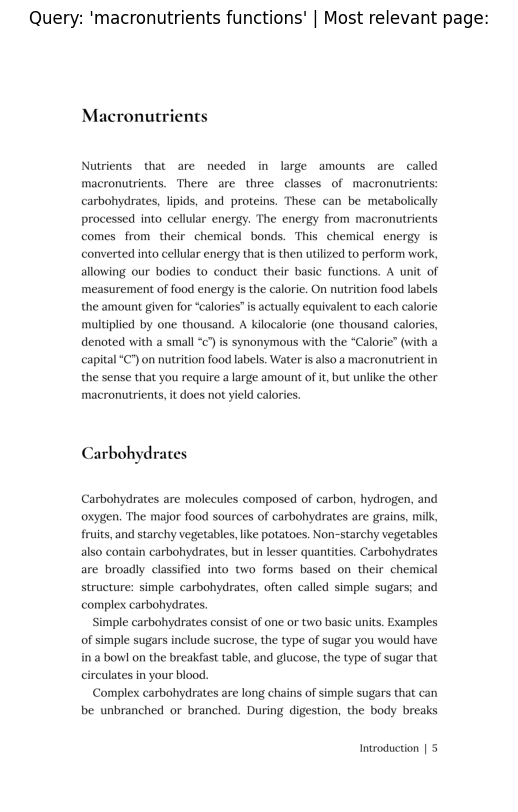

In [42]:
import fitz

pdf_path = "human-nutrition-text.pdf" 
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)
img = page.get_pixmap(dpi=300)

doc.close()

img_array  = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [52]:
def retrieve_relevant_resources(query:str,
                                embeddings:torch.tensor,
                                model:SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    query_embedding = model.encode(query,
                                   convert_to_tensor = True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding,embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time: .5f} seconds.")
    scores, indices = torch.topk(input = dot_scores,
                                 k=n_resources_to_return)
    return scores,indices
def print_top_results_and_scores(query:str,
                                 embeddings: torch.tensor,
                                 pages_and_chunk: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    
    scores,indices = retrieve_relevant_resources(query= query,
                                                 embeddings= embeddings,
                                                 n_resources_to_return= n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [53]:
query = "symptoms of pellagra"
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores,indices

[INFO] Time taken to get scores on 1684 embeddings:  0.01825 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721]),
 tensor([ 825,  856, 1540, 1559, 1535]))

In [56]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1684 embeddings:  0.00088 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and  the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s:  diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin  Water-Soluble Vitamins  |  565
Page number: 565


Score: 0.3741
car.Does it drive faster with a half-tank of gas or a full one?It does  not
matter; the car drives just as fast as long as it has gas.Similarly,  depletion
of B vitamins will cause problems in energy metabolism,  but having more than is
required to run metabolism does not speed  it up.Buyers of B-vitamin supplements
beware; B vitamins are not  stored in the body and all excess will be flushed
down the toilet  along with the extra money spent. B vitamins are naturally
present in numerous foods, and many  other foods are enrich